Building a prediction model is the third step of the Tardis Project. The goal is to use the values in our cleaned dataset to predict future delays.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import scipy as sp
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor

First, we load our cleaned dataset with pandas

In [50]:
df = pd.read_csv('cleaned_dataset.csv', delimiter=',', on_bad_lines='warn')

Then we decide which columns  

In [51]:
X = df[
    ['Month',
     'Service',
     'Departure station',
     'Arrival station',
     'Average journey time',
     'Number of scheduled trains',
     'Number of cancelled trains',
     'Number of trains delayed at departure',
     'Number of trains delayed at arrival',
     'Number of trains delayed > 15min']
]

y = [
    'Average delay of late trains at departure',
    'Average delay of all trains at departure',
    'Average delay of late trains at arrival',
    'Average delay of all trains at arrival',
    'Average delay of trains > 15min (if competing with flights)'
]

y_targets = {col: df[col].fillna(0) for col in y}

for col in X.columns:
    if X[col].dtype in [np.float64, np.int64]:
        X[col].fillna(X[col].median(), inplace=True)
    else:
        X[col].fillna(X[col].mode()[0], inplace=True)


/tmp/ipykernel_30518/1823524293.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col].fillna(X[col].mode()[0], inplace=True)
/tmp/ipykernel_30518/1823524293.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col].fillna(X[col].median(), inplace=True)


In [52]:
numeric_features = ['Average journey time',
     'Number of scheduled trains',
     'Number of cancelled trains',
     'Number of trains delayed at departure',
     'Number of trains delayed at arrival',
     'Number of trains delayed > 15min']

categorical_features = ["Month", "Service", "Departure station", "Arrival station"]

In [53]:
def build_pipeline(numeric_features, categorical_features):
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', DummyRegressor())
    ])

    return pipe

add multi output
automate tests for different model
add visualisation

In [54]:
def test_model(pipeline, model, model_name, param_grid, y_target):
    print(f"Evaluating model: {model_name}")

    pipeline.set_params(regressor=model)


    search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring=make_scorer(mean_squared_error, greater_is_better=False),
        n_jobs=1,
    )

    search.fit(X_train_small, y_train_small)

    y_pred = search.best_estimator_.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Metrics for {model_name}:")
    print(f"Predict : {y_target}")

    print(f"  RMSE: {rmse:.2f} minutes")
    print(f"  MAE:  {mae:.2f} minutes")
    print(f"  R²:   {r2:.3f}")
    print(f"Best parameters: {search.best_params_}")

    return {
        y_target: {
            'model': model_name,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'best_params': search.best_params_
        }
    }

In [55]:
pipe = build_pipeline(numeric_features, categorical_features)
results = []


Have a single function to call for each model instead of a loop
Store the different results to compare them later

In [56]:
df

,Date,Service,Departure station,Arrival station,Average journey time,Number of scheduled trains,Number of cancelled trains,Cancellation comments,Number of trains delayed at departure,Average delay of late trains at departure,...,Average delay of trains > 15min (if competing with flights),Number of trains delayed > 30min,Number of trains delayed > 60min,Pct delay due to external causes,Pct delay due to infrastructure,Pct delay due to traffic management,Pct delay due to rolling stock,Pct delay due to station management and equipment reuse,"Pct delay due to passenger handling (crowding, disabled persons, connections)",Month
0,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165.0,222,0,NaN,8,2.866667,...,5.683333,5,0,15.38,30.77,38.46,11.54,3.85,0.00,January
1,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220.0,248,1,NaN,37,9.500000,...,7.533333,17,7,NaN,NaN,NaN,NaN,NaN,NaN,January
2,2018-01,National,PARIS MONTPARNASSE,ST MALO,156.0,102,0,NaN,12,19.900000,...,6.716667,6,4,NaN,NaN,NaN,NaN,NaN,NaN,January
3,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61.0,391,2,NaN,61,0.000000,...,3.333333,6,0,21.21,42.42,9.09,21.21,6.06,0.00,January
4,2018-01,National,QUIMPER,PARIS MONTPARNASSE,223.0,256,1,NaN,0,16.316667,...,5.916667,9,0,NaN,NaN,NaN,NaN,NaN,NaN,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,2024-12,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,64.0,539,10,NaN,49,12.233333,...,27.916667,5,1,6.56,16.39,29.51,29.51,11.48,6.56,December
6885,2024-12,National,PARIS MONTPARNASSE,VANNES,158.0,284,2,NaN,27,22.483333,...,52.666667,0,0,33.33,16.67,19.44,22.22,5.56,2.78,December
6886,2024-12,National,QUIMPER,PARIS MONTPARNASSE,231.0,274,1,NaN,0,0.000000,...,56.150000,0,13,41.03,20.51,7.69,17.95,7.69,5.13,December
6887,2024-12,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,168.0,110,0,NaN,20,118.283333,...,33.400000,6,1,NaN,NaN,NaN,NaN,NaN,NaN,December


In [57]:
model1_name = "RandomForestRegressor"
model1 = RandomForestRegressor()
print(model1.get_params())
param_grid1 = {
    'regressor__max_depth': [10, 30, None],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__n_estimators': [100, 300, 500]
}

for name, y in y_targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_small = X_train.sample(frac=0.5, random_state=42)
    y_train_small = y_train.loc[X_train_small.index]

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    result = test_model(pipe, model1, model1_name, param_grid1, name)
    results.append(result)


{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Evaluating model: RandomForestRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for RandomForestRegressor:
Predict : Average delay of late trains at departure
  RMSE: 27.07 minutes
  MAE:  13.87 minutes
  R²:   -0.033
Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 500}
Evaluating model: RandomForestRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for RandomForestRegressor:
Predict : Average delay of all trains at departure
  RMSE: 7.58 minutes
  MAE:  3.68 minutes
  R²:   -0.027
Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 500}
Evaluating model: RandomForestRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for RandomForestRegressor:
Predict : Average delay of late trains at arrival
  RMSE: 66.44 minutes
  MAE:  31.22 minutes
  R²:   -0.016
Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 500}
Evaluating model: RandomForestRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for RandomForestRegressor:
Predict : Average delay of all trains at arrival
  RMSE: 12.36 minutes
  MAE:  5.87 minutes
  R²:   0.009
Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 300}
Evaluating model: RandomForestRegressor
Metrics for RandomForestRegressor:
Predict : Average delay of trains > 15min (if competing with flights)
  RMSE: 73.05 minutes
  MAE:  34.66 minutes
  R²:   -0.015
Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 300}


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [58]:
model2_name = "GradientBoostingRegressor"
model2 = GradientBoostingRegressor()
print(model2.get_params())
param_grid2 = {
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_leaf': [20, 50, 100],
}

for name, y in y_targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_small = X_train.sample(frac=0.5, random_state=42)
    y_train_small = y_train.loc[X_train_small.index]

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    result = test_model(pipe, model2, model2_name, param_grid2, name)
    results.append(result)


{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Evaluating model: GradientBoostingRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for GradientBoostingRegressor:
Predict : Average delay of late trains at departure
  RMSE: 26.57 minutes
  MAE:  13.38 minutes
  R²:   0.005
Best parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 100}
Evaluating model: GradientBoostingRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for GradientBoostingRegressor:
Predict : Average delay of all trains at departure
  RMSE: 7.43 minutes
  MAE:  3.70 minutes
  R²:   0.013
Best parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 20}
Evaluating model: GradientBoostingRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for GradientBoostingRegressor:
Predict : Average delay of late trains at arrival
  RMSE: 65.85 minutes
  MAE:  30.65 minutes
  R²:   0.002
Best parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 100}
Evaluating model: GradientBoostingRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for GradientBoostingRegressor:
Predict : Average delay of all trains at arrival
  RMSE: 12.30 minutes
  MAE:  6.02 minutes
  R²:   0.019
Best parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 20}
Evaluating model: GradientBoostingRegressor
Metrics for GradientBoostingRegressor:
Predict : Average delay of trains > 15min (if competing with flights)
  RMSE: 72.46 minutes
  MAE:  34.07 minutes
  R²:   0.001
Best parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 50}


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [59]:
model3_name = "LinearRegression"
model3 = LinearRegression()
print(model3.get_params())
param_grid3 = {}

for name, y in y_targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_small = X_train.sample(frac=0.4, random_state=42)
    y_train_small = y_train.loc[X_train_small.index]

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    result = test_model(pipe, model3, model3_name, param_grid3, name)
    results.append(result)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Evaluating model: LinearRegression


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for LinearRegression:
Predict : Average delay of late trains at departure
  RMSE: 18478198823.62 minutes
  MAE:  2633989534.06 minutes
  R²:   -481315000582847616.000
Best parameters: {}
Evaluating model: LinearRegression


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for LinearRegression:
Predict : Average delay of all trains at departure
  RMSE: 30643325169.16 minutes
  MAE:  4368077115.51 minutes
  R²:   -16781854343628230656.000
Best parameters: {}
Evaluating model: LinearRegression


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for LinearRegression:
Predict : Average delay of late trains at arrival
  RMSE: 300898425083.25 minutes
  MAE:  42891804899.42 minutes
  R²:   -20837025726081896448.000
Best parameters: {}
Evaluating model: LinearRegression


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for LinearRegression:
Predict : Average delay of all trains at arrival
  RMSE: 19109244384.43 minutes
  MAE:  2723942416.39 minutes
  R²:   -2369345473997185536.000
Best parameters: {}
Evaluating model: LinearRegression
Metrics for LinearRegression:
Predict : Average delay of trains > 15min (if competing with flights)
  RMSE: 43644315077.64 minutes
  MAE:  6221313576.10 minutes
  R²:   -362362833205075712.000
Best parameters: {}


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [60]:
model4_name = "HistGradientBoostingRegressor"
model4 = HistGradientBoostingRegressor()
param_grid4 = {
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_iter': [100, 200, 500],
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_leaf': [20, 50, 100],
    'regressor__l2_regularization': [0.0, 0.1, 1.0]
}

for name, y in y_targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_small = X_train.sample(frac=0.5, random_state=42)
    y_train_small = y_train.loc[X_train_small.index]

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    result = test_model(pipe, model4, model4_name, param_grid4, name)
    results.append(result)



Evaluating model: HistGradientBoostingRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for HistGradientBoostingRegressor:
Predict : Average delay of late trains at departure
  RMSE: 26.55 minutes
  MAE:  13.36 minutes
  R²:   0.006
Best parameters: {'regressor__l2_regularization': 0.0, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 10, 'regressor__max_iter': 100, 'regressor__min_samples_leaf': 100}
Evaluating model: HistGradientBoostingRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for HistGradientBoostingRegressor:
Predict : Average delay of all trains at departure
  RMSE: 7.37 minutes
  MAE:  3.60 minutes
  R²:   0.029
Best parameters: {'regressor__l2_regularization': 0.1, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 10, 'regressor__max_iter': 200, 'regressor__min_samples_leaf': 100}
Evaluating model: HistGradientBoostingRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for HistGradientBoostingRegressor:
Predict : Average delay of late trains at arrival
  RMSE: 65.89 minutes
  MAE:  30.70 minutes
  R²:   0.001
Best parameters: {'regressor__l2_regularization': 0.0, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__max_iter': 100, 'regressor__min_samples_leaf': 100}
Evaluating model: HistGradientBoostingRegressor


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metrics for HistGradientBoostingRegressor:
Predict : Average delay of all trains at arrival
  RMSE: 12.28 minutes
  MAE:  6.02 minutes
  R²:   0.021
Best parameters: {'regressor__l2_regularization': 0.0, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__max_iter': 100, 'regressor__min_samples_leaf': 20}
Evaluating model: HistGradientBoostingRegressor
Metrics for HistGradientBoostingRegressor:
Predict : Average delay of trains > 15min (if competing with flights)
  RMSE: 72.46 minutes
  MAE:  34.07 minutes
  R²:   0.001
Best parameters: {'regressor__l2_regularization': 0.0, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__max_iter': 100, 'regressor__min_samples_leaf': 50}


/usr/lib/python3/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


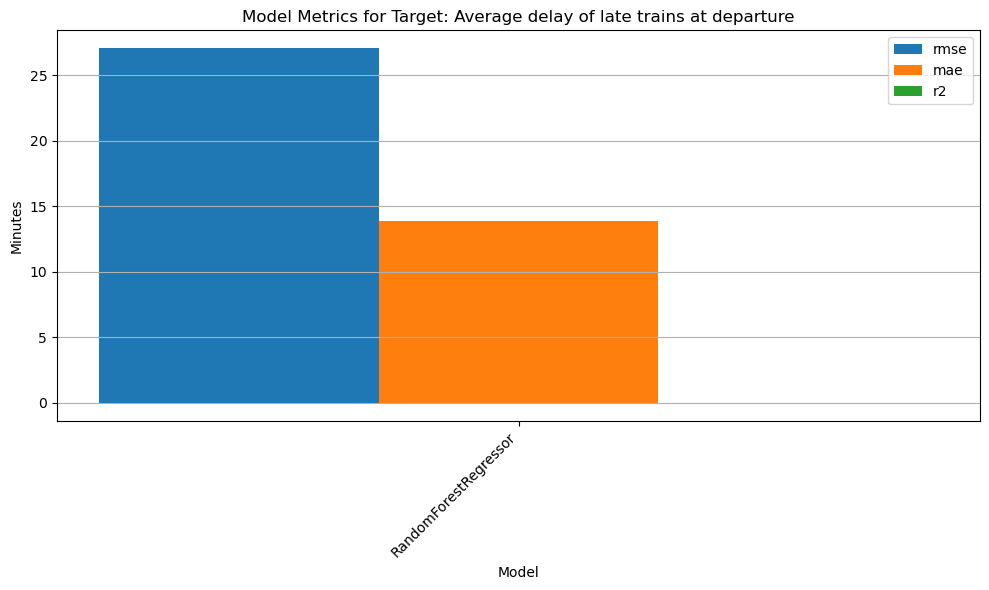

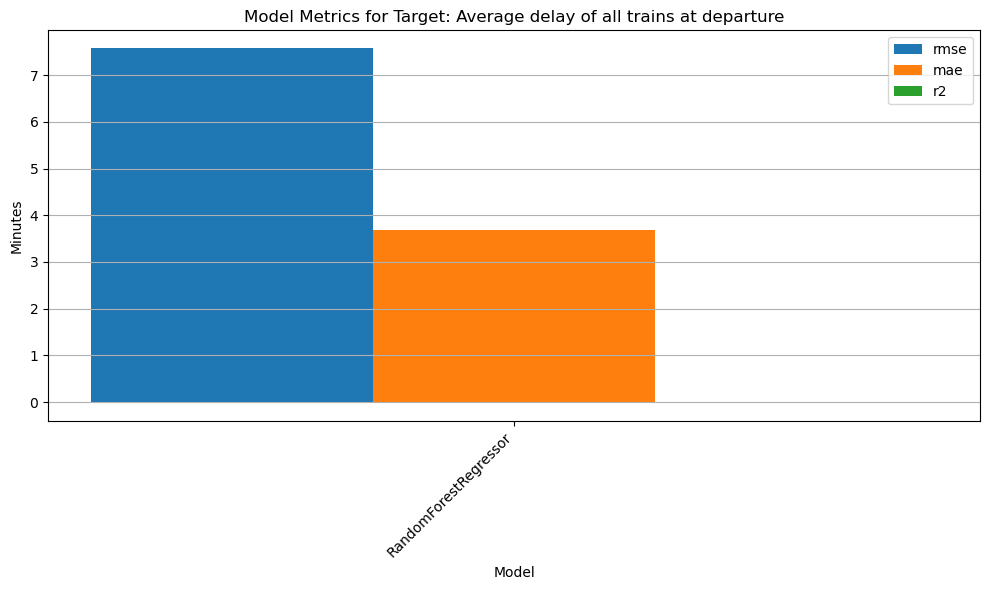

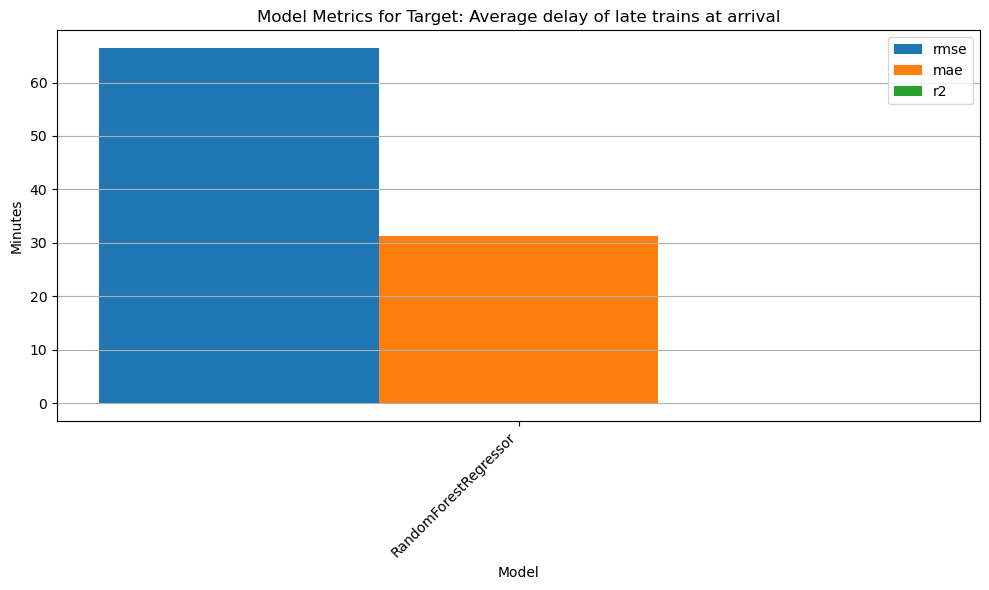

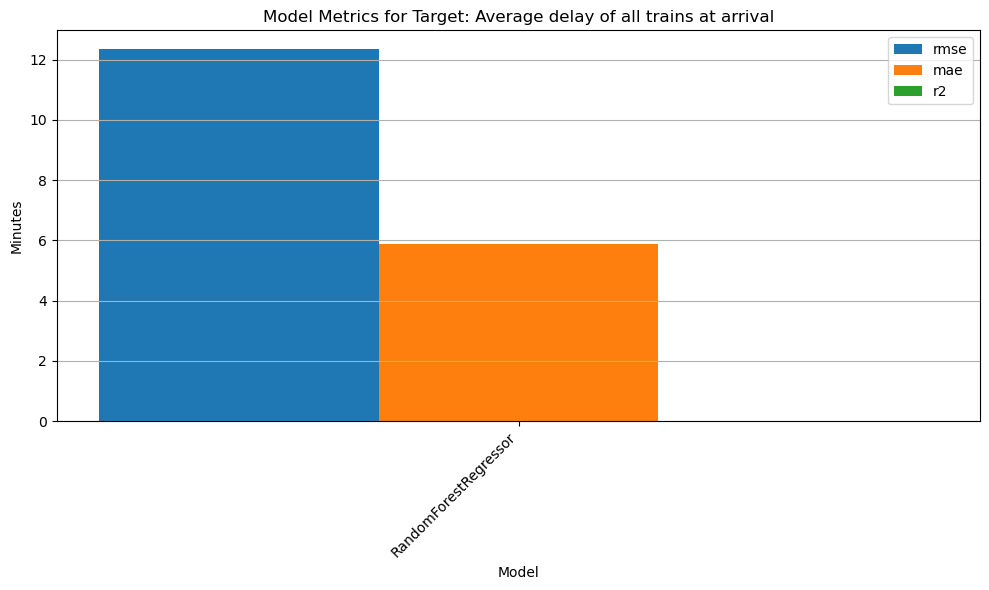

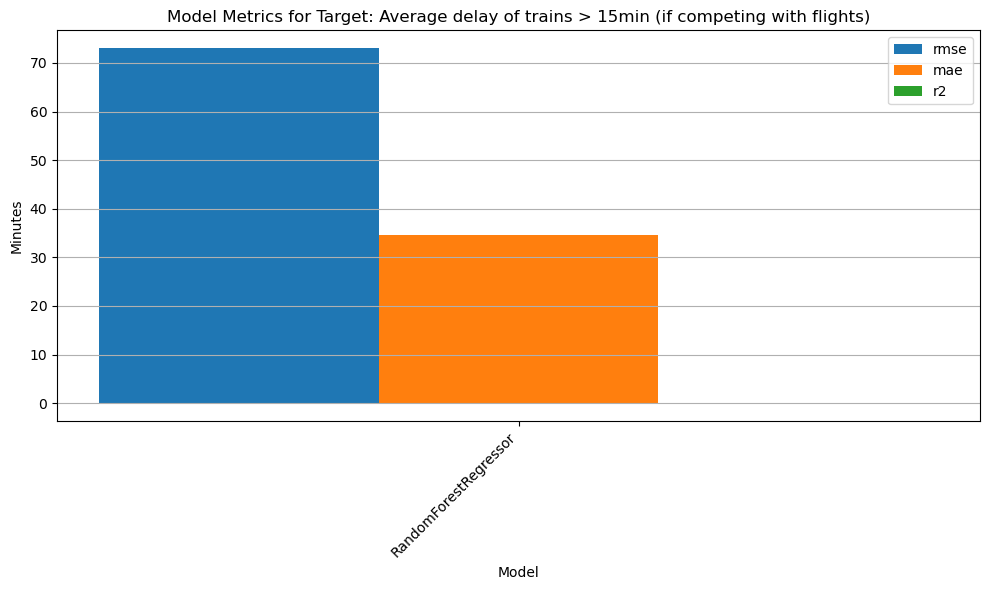

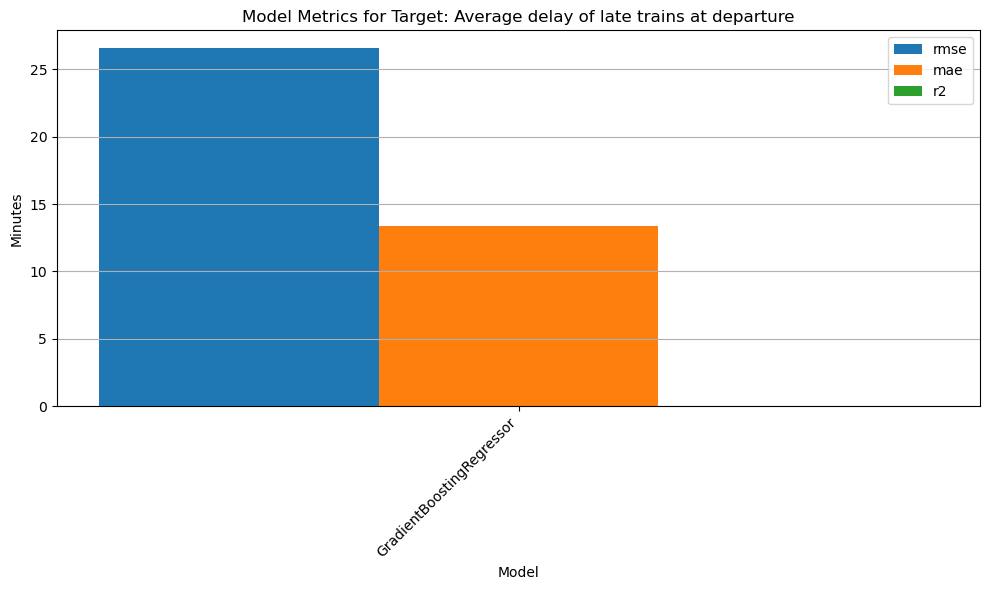

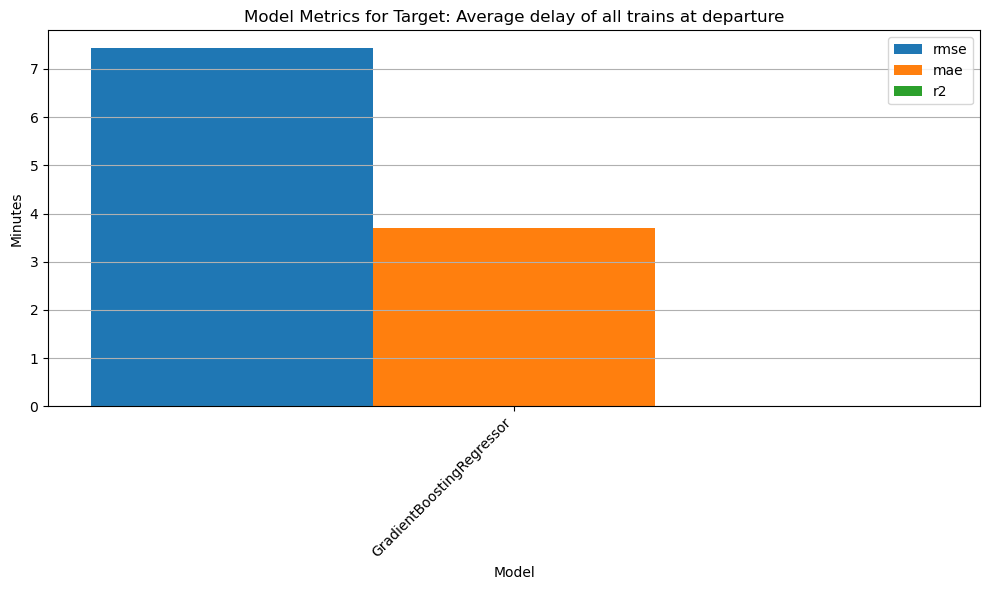

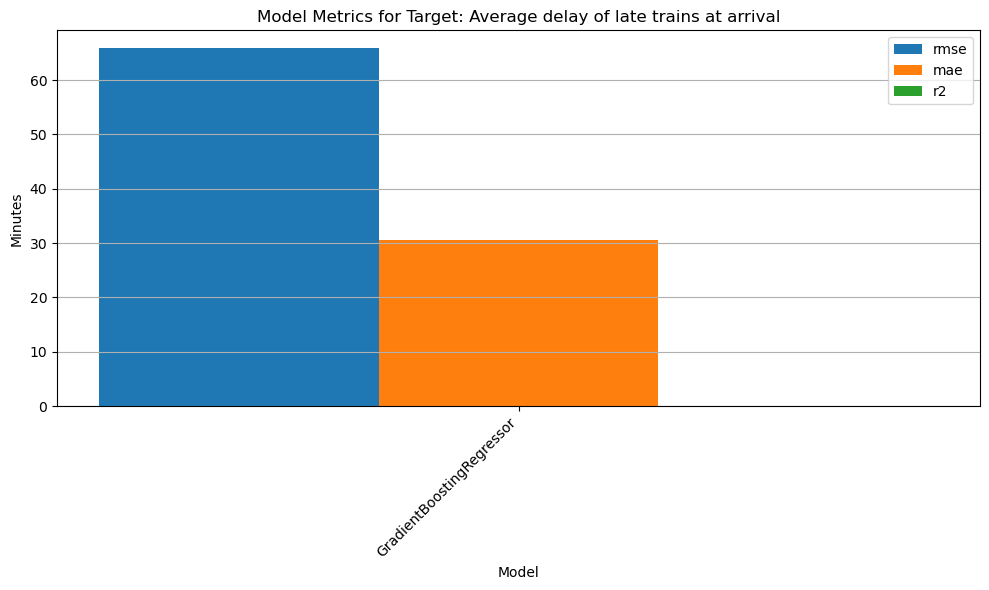

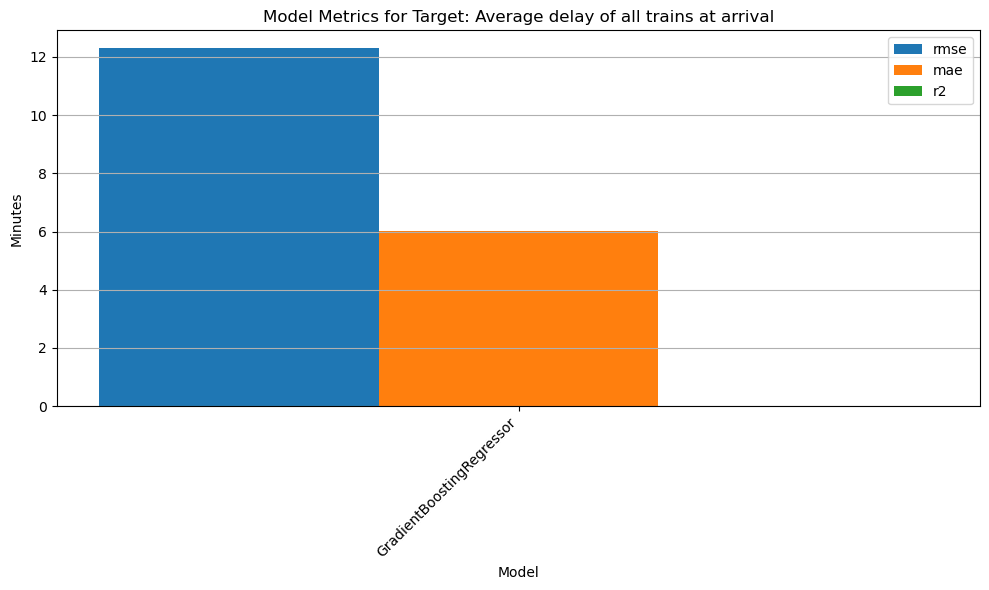

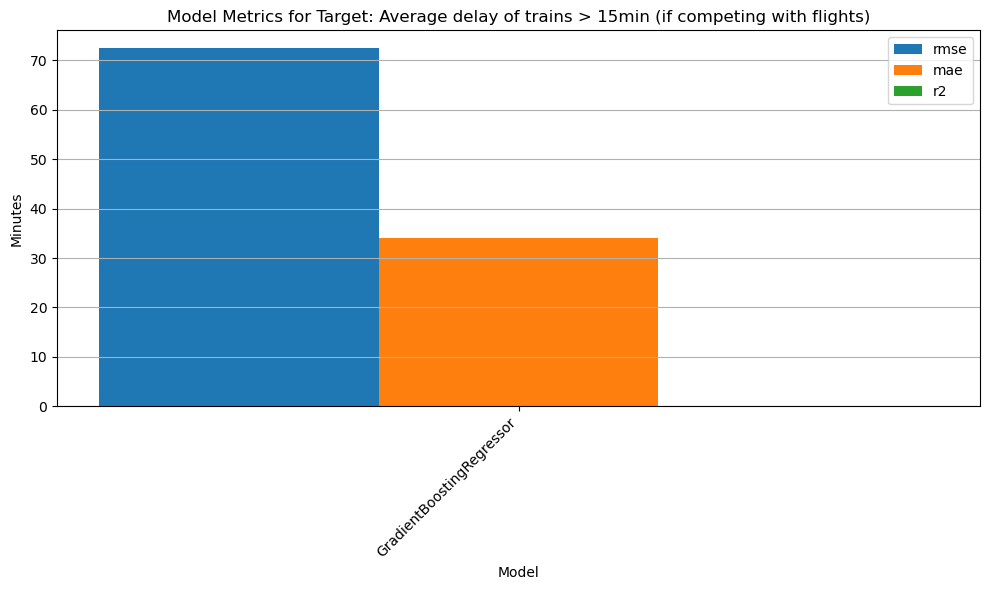

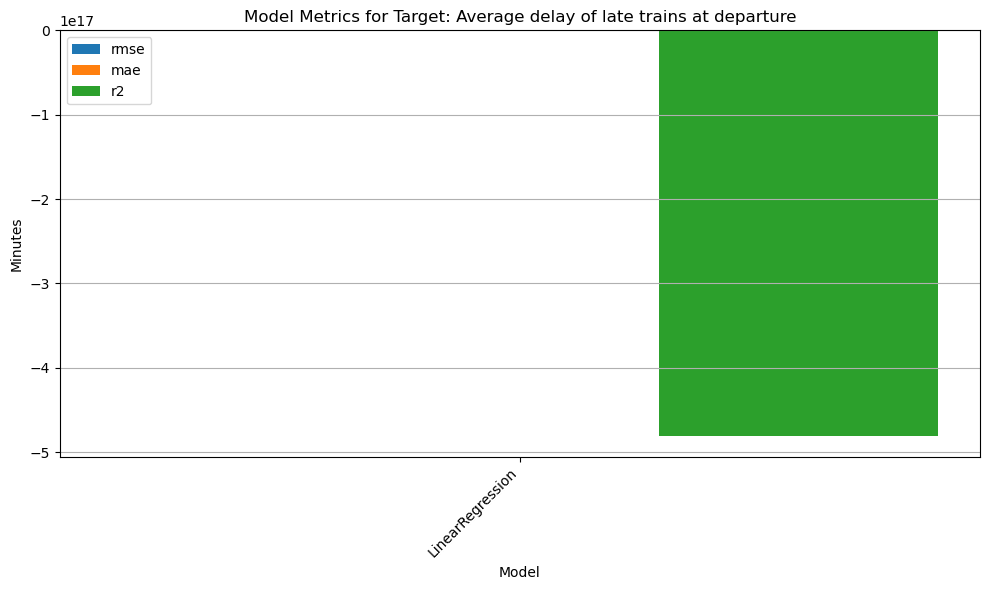

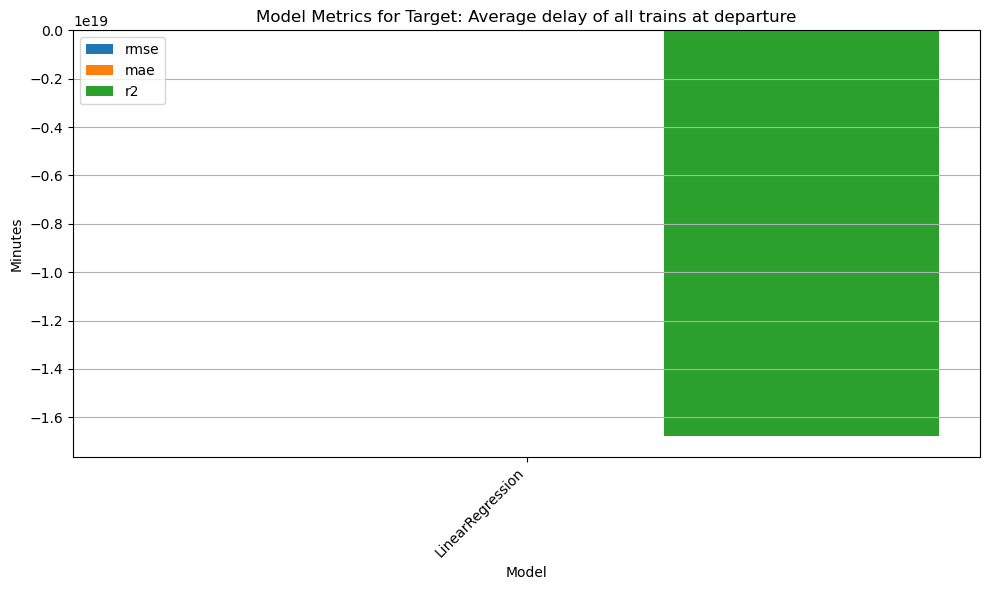

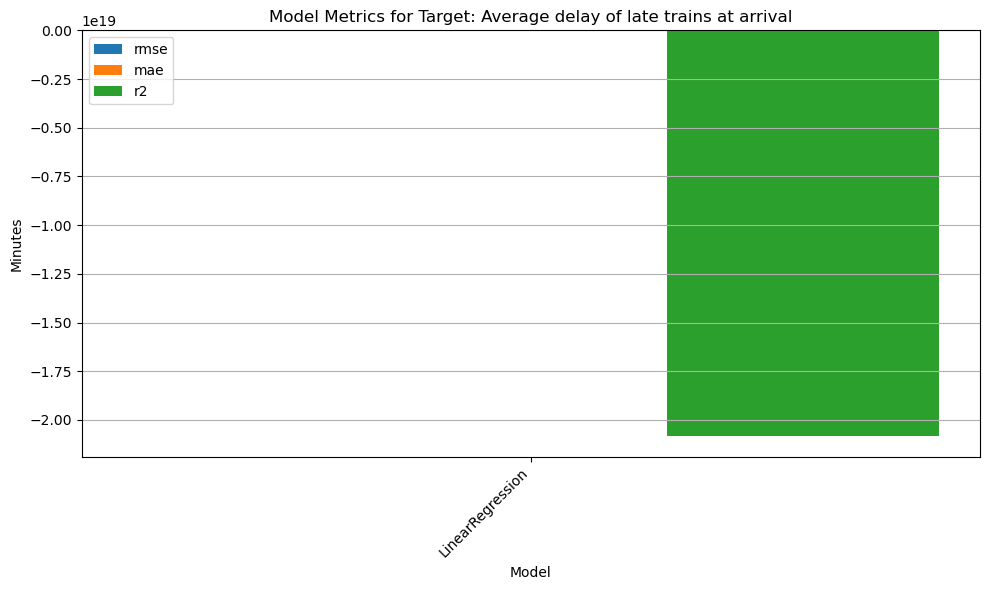

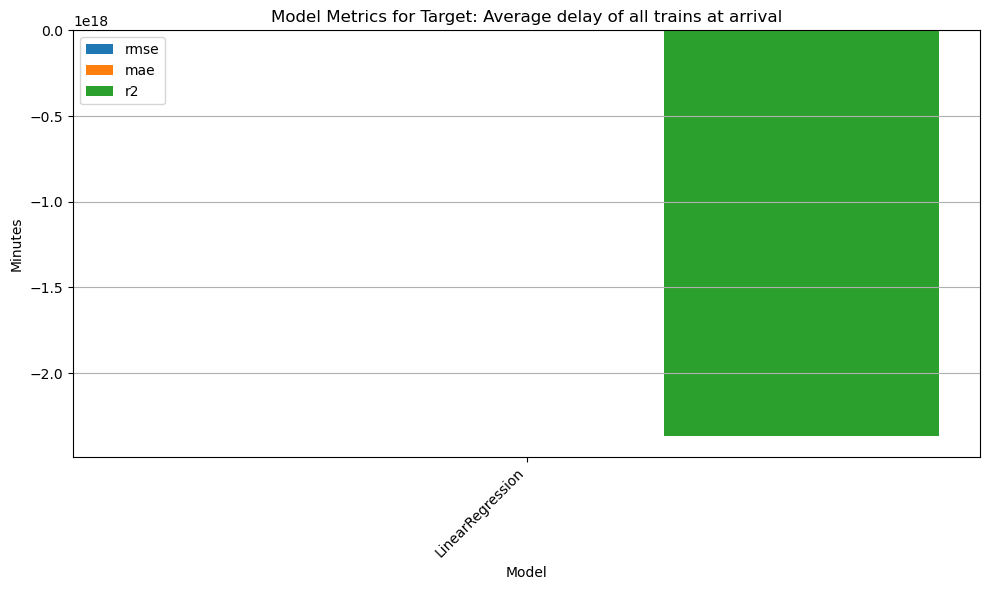

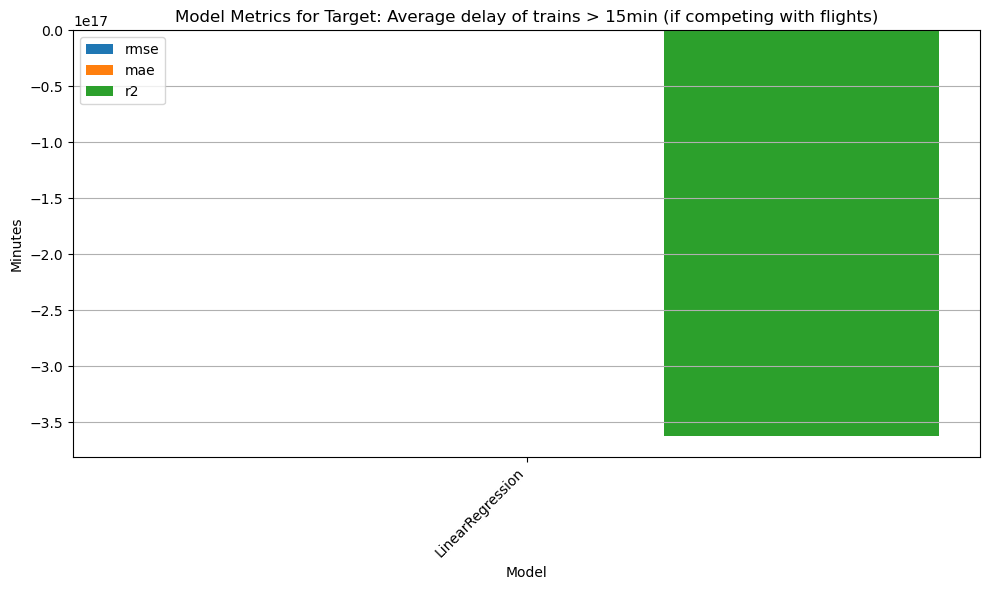

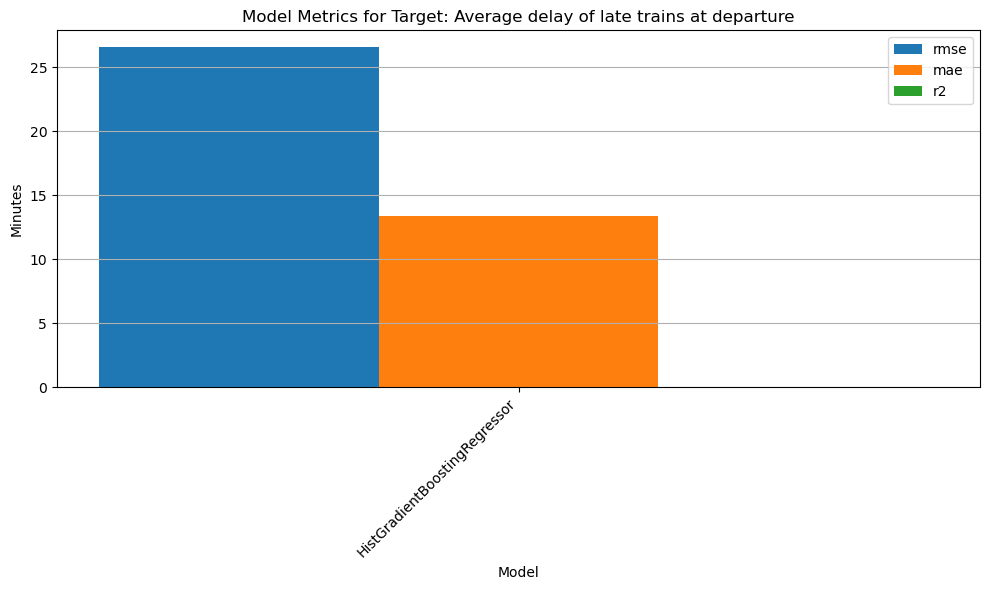

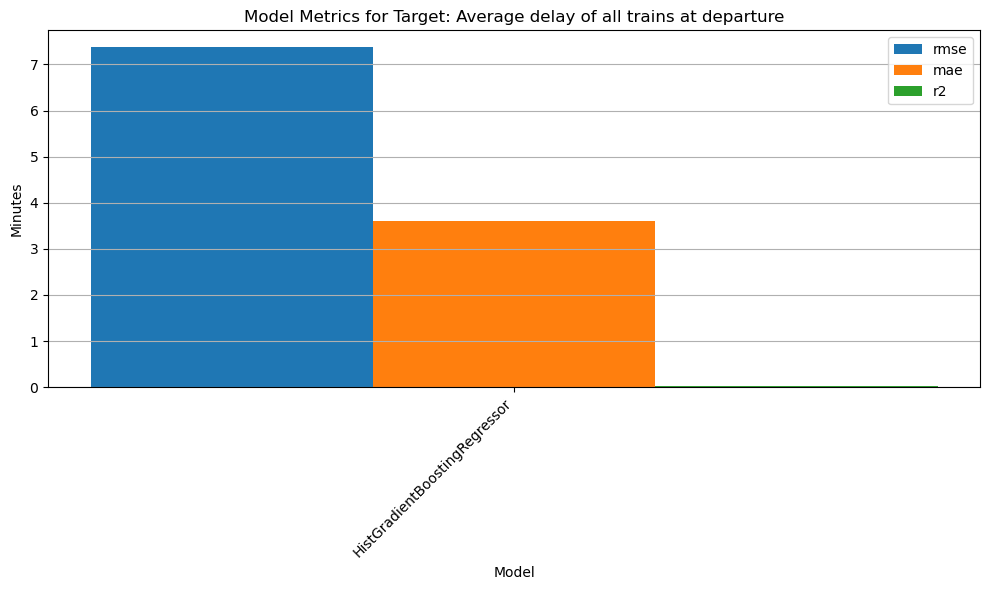

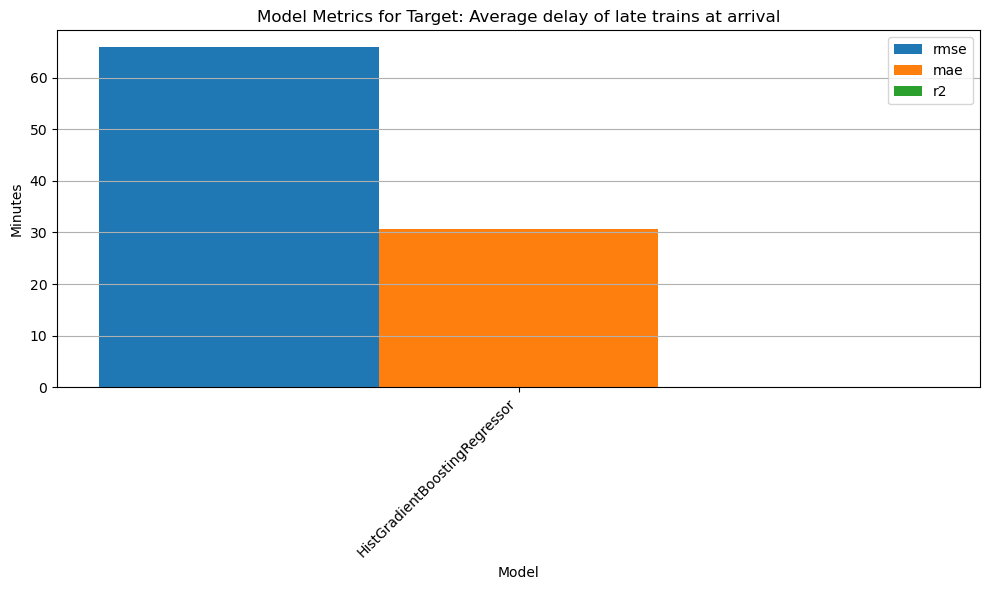

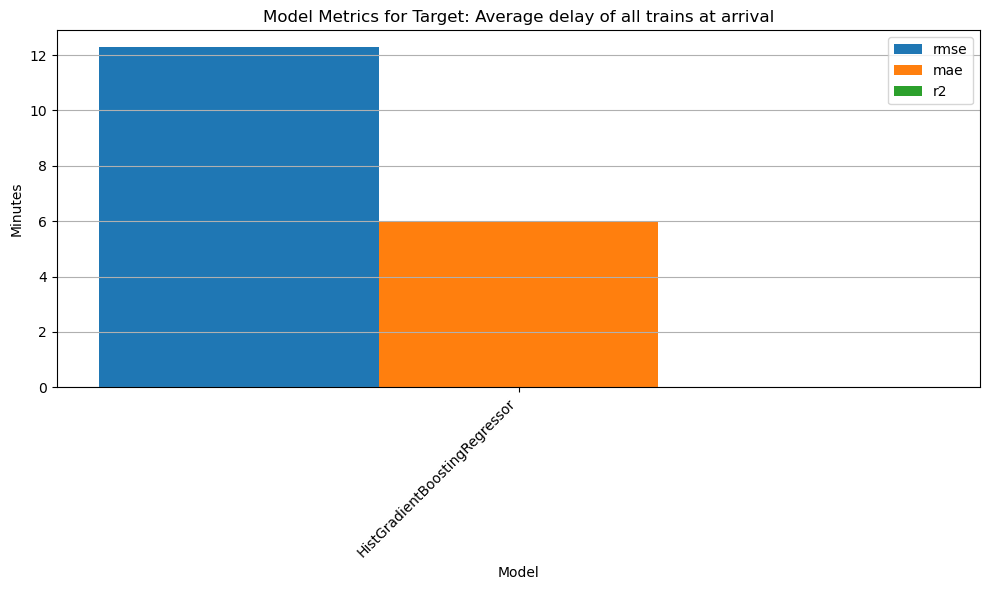

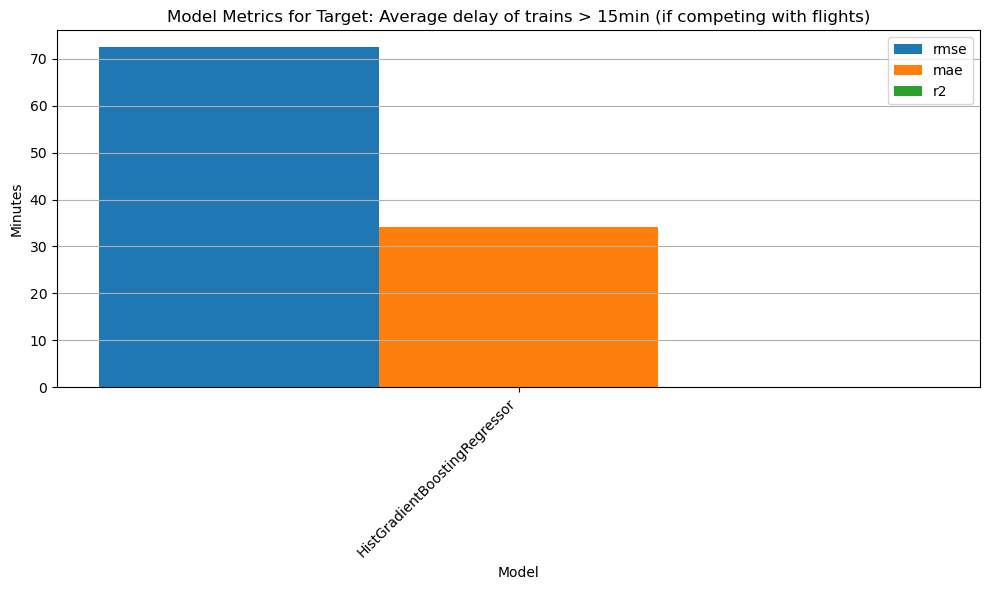

In [64]:
for result in results:
    for target_name, v in result.items():
        results_df = pd.DataFrame([{
            'model': v['model'],
            'rmse': v['rmse'],
            'mae': v['mae'],
            'r2': v['r2']
        }])

        metrics_df = results_df.melt(
            id_vars='model',
            value_vars=['rmse', 'mae', 'r2'],
            var_name='Metric',
            value_name='Value'
        )

        plt.figure(figsize=(10, 6))
        width = 0.25
        for i, metric in enumerate(['rmse', 'mae', 'r2']):
            subset = metrics_df[metrics_df['Metric'] == metric]
            plt.bar(
                np.arange(len(subset)) + i * width,
                subset['Value'],
                width=width,
                label=metric
            )

        plt.xticks(
            np.arange(len(results_df)) + width,
            results_df['model'],
            rotation=45,
            ha='right'
        )
        plt.title(f"Model Metrics for Target: {target_name}")
        plt.xlabel("Model")
        plt.ylabel("Minutes")
        plt.legend()
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()


In [66]:
csv_results = []

for result in results:
    for target, model_data in result.items():
        row = {
            'target': target,
            'model': model_data['model'],
            'rmse': model_data['rmse'],
            'mae': model_data['mae'],
            'r2': model_data['r2'],
            'best_params': str(model_data['best_params'])
        }
        csv_results.append(row)

results_df = pd.DataFrame(csv_results)
results_df.to_csv('model_results.csv', index=False)